# Final Predictions

## Purpose
Project property-level rents to 2030 by applying SA2-level predicted growth (from SARIMAX forecasts) to 2025 baseline rent predictions. Identify high-growth SA2s, property types, and bedroom/bathroom combinations for insights.

## Inputs
- `baseline_rent_predictions_2025.csv` – property-level predicted weekly rents for 2025  
- `growth_SARIMAX_SA2.csv` – SA2-level predicted total growth (%) from 2025–2030  
- `LGA_2021_AUST_GDA2020.shp` – LGA boundary shapefile for spatial mapping (imputation)

## Outputs
- `predicted_rent_2030` column in property-level dataframe  
- Aggregated SA2-level median predicted rents and growth  
- Top 10 SA2s by predicted median rent and growth  
- Top property types and bedroom/bathroom combinations by growth  
- Bar plots visualising top SA2s and growth patterns

## Key Steps
1. Load baseline 2025 property-level predictions and SA2-level growth multipliers.  
2. Merge SA2 growth multipliers with property data and compute 2030 predicted rents.  
3. Check for missing SA2 multipliers; impute using LGA average or global mean as fallback.  
4. Aggregate property-level 2030 predictions to SA2 level for median rents and property counts.  
5. Identify top 10 SA2s by absolute predicted rent and by predicted growth %.  
6. Compute median predicted rent and growth per SA2 × property type; identify top property types.  
7. Analyse bedroom/bathroom combinations for high-growth patterns.  
8. Visualise results using horizontal bar plots for top SA2s and growth insights.  


In [61]:
# libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# load data
pred_growth = pd.read_csv("../../datasets/results/growth_SARIMAX_SA2.csv")
baseline_pred = pd.read_csv("../../datasets/results/baseline_rent_predictions_2025.csv")

In [42]:
# rename for consistency
pred_growth.rename(columns={'SA2_CODE21': 'sa2_code'}, inplace=True)

# Convert percentage growth to multiplier
pred_growth['sa2_growth_multiplier'] = 1 + pred_growth['Total_Growth_%'] / 100

# Merge with property-level data on sa2_code
baseline_pred = baseline_pred.merge(pred_growth[['sa2_code', 'sa2_growth_multiplier']], on='sa2_code', how='left')

# Apply multiplier to get 2030 predicted rents
baseline_pred['predicted_rent_2030'] = baseline_pred['predicted_weekly_rent'] * baseline_pred['sa2_growth_multiplier']

baseline_pred.isnull().sum()

sa2_code                                  0
sa2_name                                  0
suburb                                    0
postcode                                  0
weekly_rent                               0
bond                                      0
address                                  91
lat                                       0
lon                                       0
bedrooms                                  0
bathrooms                                 0
carspaces                                 0
property_type                             0
balcony                                   0
car_parking                               0
heating                                   0
air_conditioning                          0
builtin_wardrobes                         0
swimming_pool                             0
ensuite                                   0
dishwasher                                0
garden                                    0
gym                             

In [43]:
# check merge quality
missing_growth = baseline_pred[baseline_pred['sa2_growth_multiplier'].isna()]
print(f"Number of properties with missing growth multiplier: {len(missing_growth)}")

domain_sa2_unique = baseline_pred['sa2_code'].unique()
pred_growth_sa2_unique = pred_growth['sa2_code'].unique()

missing_in_growth = set(domain_sa2_unique) - set(pred_growth_sa2_unique)
extra_in_growth = set(pred_growth_sa2_unique) - set(domain_sa2_unique)

print(f"Number of unique SA2s in property data: {len(domain_sa2_unique)}")
print(f"Number of unique SA2s in predicted growth: {len(pred_growth_sa2_unique)}")

Number of properties with missing growth multiplier: 7879
Number of unique SA2s in property data: 478
Number of unique SA2s in predicted growth: 138


## Impute missing multipliers using lga level

In [44]:
# Add lga code to properties 

lga_boundaries = gpd.read_file("../../datasets/district_shape/LGA_2021_AUST_GDA2020_SHP/LGA_2021_AUST_GDA2020.shp")[['LGA_CODE21', 'geometry']]
properties_gdf = gpd.GeoDataFrame(baseline_pred, geometry=gpd.points_from_xy(baseline_pred['lon'], baseline_pred['lat']), crs="EPSG:4326")

properties_gdf = properties_gdf.to_crs(lga_boundaries.crs)

# join 
properties_with_lga = gpd.sjoin(properties_gdf, lga_boundaries, how="left",  predicate="within")

In [45]:
# Attach LGA to growth data 
pred_growth = pred_growth.merge(properties_with_lga[['sa2_code', 'LGA_CODE21']].drop_duplicates(), on='sa2_code', how='left')

# Compute average per LGA
lga_avg = pred_growth.groupby('LGA_CODE21')['sa2_growth_multiplier'].mean().reset_index()
lga_avg.head()

,LGA_CODE21,sa2_growth_multiplier
0,20570,1.250315
1,20660,1.199198
2,20830,1.320961
3,20910,1.212919
4,21010,1.395532


In [46]:
lga_avg = pred_growth.groupby('LGA_CODE21')['sa2_growth_multiplier'].mean().reset_index()
lga_avg = lga_avg.rename(columns={'sa2_growth_multiplier': 'sa2_growth_multiplier_lga_avg'})

In [47]:
# Impute missing using lga level multiplier
mask_missing_sa2 = properties_with_lga['sa2_growth_multiplier'].isna()

# Map LGA average multiplier to these missing rows
properties_with_lga.loc[mask_missing_sa2, 'predicted_rent_2030'] = (properties_with_lga.loc[mask_missing_sa2, 'predicted_weekly_rent'] *
properties_with_lga.loc[mask_missing_sa2, 'LGA_CODE21'].map(lga_avg.set_index('LGA_CODE21')['sa2_growth_multiplier_lga_avg']))
properties_with_lga.isnull().sum()

sa2_code                                  0
sa2_name                                  0
suburb                                    0
postcode                                  0
weekly_rent                               0
bond                                      0
address                                  91
lat                                       0
lon                                       0
bedrooms                                  0
bathrooms                                 0
carspaces                                 0
property_type                             0
balcony                                   0
car_parking                               0
heating                                   0
air_conditioning                          0
builtin_wardrobes                         0
swimming_pool                             0
ensuite                                   0
dishwasher                                0
garden                                    0
gym                             

In [48]:
# Compute fallback multiplier
global_mean_multiplier = properties_with_lga['sa2_growth_multiplier'].mean(skipna=True)

# impute
mask_still_missing = properties_with_lga['predicted_rent_2030'].isna()
properties_with_lga.loc[mask_still_missing, 'predicted_rent_2030'] = (
    properties_with_lga.loc[mask_still_missing, 'predicted_weekly_rent'] *
    global_mean_multiplier
)

## Results

In [49]:
# Aggregate to sa2 level for insights
sa2_2030_pred = properties_with_lga.groupby(['sa2_code', 'sa2_name']).agg(median_predicted_rent_2030=('predicted_rent_2030', 'median'), num_properties=('predicted_rent_2030', 'count')).reset_index()

### Top 10 SA2 Absolute Rent

In [50]:
# Top 10 highest absolute rental 
top_10_sa2 = sa2_2030_pred.sort_values('median_predicted_rent_2030', ascending=False).head(10)
print(top_10_sa2[['sa2_name', 'median_predicted_rent_2030']])

                        sa2_name  median_predicted_rent_2030
174              Brighton (Vic.)                 1912.680844
314           Emerald - Cockatoo                 1596.422779
220           Plenty - Yarrambat                 1451.640087
175                Brighton East                 1401.439572
431                  Mount Eliza                 1367.042884
176  Highett (West) - Cheltenham                 1302.088149
287      Warrandyte - Wonga Park                 1291.018545
178     Sandringham - Black Rock                 1286.490596
286      Donvale - Park Orchards                 1286.026576
429                     Flinders                 1265.888862


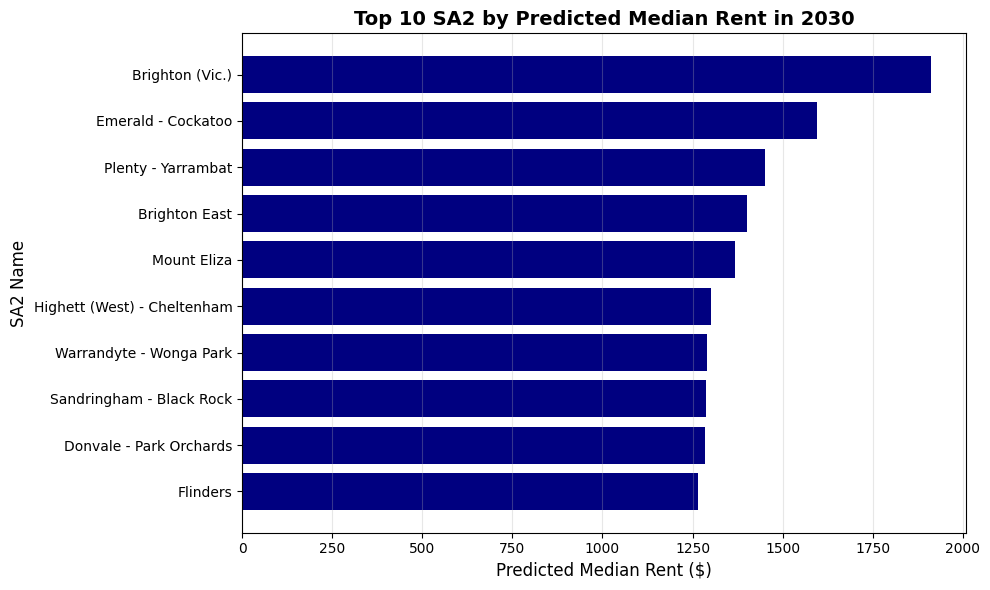

In [51]:
# Plot
top_10_sa2 = sa2_2030_pred.sort_values('median_predicted_rent_2030', ascending=False).head(10)


plt.figure(figsize=(10, 6))
plt.barh(
    y=top_10_sa2['sa2_name'],
    width=top_10_sa2['median_predicted_rent_2030'],
    color='navy'
)

plt.gca().invert_yaxis()

plt.title("Top 10 SA2 by Predicted Median Rent in 2030", fontsize=14, fontweight='bold')
plt.xlabel("Predicted Median Rent ($)", fontsize=12)
plt.ylabel("SA2 Name", fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

### Top 10 SA2 Growth

In [57]:
# Compute growth % from predicted 2025 rent to predicted 2030 rent
properties_with_lga['predicted_growth_%'] = ((properties_with_lga['predicted_rent_2030'] - properties_with_lga['predicted_weekly_rent']) / properties_with_lga['predicted_weekly_rent']) * 100

# Aggregate to SA2 level
sa2_growth = properties_with_lga.groupby(['sa2_code', 'sa2_name']).agg(median_growth_pct=('predicted_growth_%', 'median'),num_properties=('predicted_rent_2030', 'count')).reset_index()

# Top 10 SA2s by growth %
top_10_growth_sa2 = sa2_growth.sort_values('median_growth_pct', ascending=False).head(10)

top_10_growth_sa2.head()

,sa2_code,sa2_name,median_growth_pct,num_properties
315,212011546,Beaconsfield - Officer,65.662864,80
314,212011289,Emerald - Cockatoo,65.662864,3
318,212011549,Pakenham - North East,65.662864,32
317,212011548,Koo Wee Rup,65.662864,12
316,212011547,Bunyip - Garfield,65.662864,6


## Recommendation Insights

In [53]:
cols_needed = ['sa2_name', 'property_type_grouped', 'predicted_weekly_rent', 'predicted_rent_2030']
assert all(col in properties_with_lga.columns for col in cols_needed), "Missing columns in dataframe!"

# Compute median rent and growth per SA2 × property type
sa2_property_summary = (
    properties_with_lga.groupby(['sa2_name', 'property_type_grouped'])
    .agg(
        median_predicted_rent_2030=('predicted_rent_2030', 'median'),
        median_predicted_rent_now=('predicted_weekly_rent', 'median'),
        num_properties=('predicted_rent_2030', 'count')
    )
    .reset_index()
)

In [54]:
#  Compute growth percentage
sa2_property_summary['predicted_growth_pct'] = ((sa2_property_summary['median_predicted_rent_2030'] - sa2_property_summary['median_predicted_rent_now']) / sa2_property_summary['median_predicted_rent_now'] * 100)

# Get top property types by growth per SA2
top_property_types = (
    sa2_property_summary.sort_values(['sa2_name', 'predicted_growth_pct'], ascending=[True, False])
    .groupby('sa2_name')
    .head(1)
    .reset_index(drop=True)
)

#  Get overall top growth property types across all SA2s
top_overall_growth = sa2_property_summary.sort_values('predicted_growth_pct', ascending=False).head(10)

# Display results
print("\n Top 10 high-growth property types overall:")
top_overall_growth[['sa2_name', 'property_type_grouped', 'predicted_growth_pct', 'median_predicted_rent_2030']]


 Top 10 high-growth property types overall:


,sa2_name,property_type_grouped,predicted_growth_pct,median_predicted_rent_2030
798,Pakenham - South West,Townhouse,65.662864,886.913118
788,Pakenham - North East,Apartment,65.662864,817.235334
789,Pakenham - North East,House,65.662864,930.931315
790,Pakenham - North East,Townhouse,65.662864,892.848868
171,Bunyip - Garfield,House,65.662864,971.481906
170,Bunyip - Garfield,Apartment,65.662864,834.032588
72,Beaconsfield - Officer,Apartment,65.662864,879.568737
796,Pakenham - South West,Apartment,65.662864,781.273157
791,Pakenham - North West,House,65.662864,1016.699336
792,Pakenham - North West,Townhouse,65.662864,919.523820


In [55]:
# See bath bed pattern 
beds_baths_summary = properties_with_lga.groupby(['sa2_name', 'bedrooms', 'bathrooms']).agg(median_predicted_rent_2030=('predicted_rent_2030', 'median'), median_predicted_rent_now=('predicted_weekly_rent', 'median'),num_properties=('predicted_rent_2030', 'count')).reset_index()
beds_baths_summary['predicted_growth_pct'] = ((beds_baths_summary['median_predicted_rent_2030'] - beds_baths_summary['median_predicted_rent_now'])/ beds_baths_summary['median_predicted_rent_now'] * 100)

In [56]:
top_growth_combinations = beds_baths_summary.sort_values('predicted_growth_pct', ascending=False).head(10)
top_growth_combinations

,sa2_name,bedrooms,bathrooms,median_predicted_rent_2030,median_predicted_rent_now,num_properties,predicted_growth_pct
168,Beaconsfield - Officer,5,2,1133.374755,684.145335,2,65.662864
1366,Koo Wee Rup,3,2,930.070249,561.423500,2,65.662864
890,Emerald - Cockatoo,3,1,928.917799,560.727840,1,65.662864
1835,Pakenham - North West,5,2,1183.232286,714.241115,2,65.662864
1825,Pakenham - North East,3,1,885.877974,534.747470,2,65.662864
404,Bunyip - Garfield,4,2,962.725017,581.135080,2,65.662864
165,Beaconsfield - Officer,3,1,877.859941,529.907500,2,65.662864
1832,Pakenham - North West,3,2,923.661705,557.555075,10,65.662864
1833,Pakenham - North West,4,1,1029.098539,621.200500,1,65.662864
1838,Pakenham - South East,2,2,834.331857,503.632400,1,65.662864
